##  Infrabel Open Data platform

Raw Punctuality data from one day of train activity, 06/06/2019

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from datetime import datetime
from datetime import timedelta

from scipy.stats import binom

import matplotlib.pyplot as plt
FIGSIZE = (12.0, 5.0)
plt.rcParams['figure.figsize'] = (12.0, 5.0)

pd.options.display.max_rows = 55
pd.options.display.max_colwidth = 500

In [2]:
#French file
point = pd.read_csv('data_raw_punctuality_xlsx.csv', sep=';')

point.head()

,Date de départ,Numéro du train,Relation,Opérateur,Ligne de départ,Heure réelle d'arrivée,Heure réelle de départ,Heure prévue d'arrivée,Heure prévue de départ,Retard à l'arrivée,Retard au départ,Direction de la relation,Nom du point d'arrêt,Ligne à l'arrivée,Date prévue d'arrivée,Date prévue de départ,Date réelle d'arrivée,Date réelle de départ
0,2019-06-06,115,IC 33,SNCB/NMBS,42,15:14:33,15:14:33,15:12:00,15:12:00,153.0,153.0,IC 33: LUXEMBOURG -> LIERS,STOUMONT,42,2019-06-06,2019-06-06,2019-06-06,2019-06-06
1,2019-06-06,115,IC 33,SNCB/NMBS,42,15:23:48,15:24:48,15:22:00,15:23:00,108.0,108.0,IC 33: LUXEMBOURG -> LIERS,AYWAILLE,42,2019-06-06,2019-06-06,2019-06-06,2019-06-06
2,2019-06-06,115,IC 33,SNCB/NMBS,34,15:56:00,16:00:23,15:54:00,16:01:00,120.0,-37.0,IC 33: LUXEMBOURG -> LIERS,LIEGE-GUILLEMINS,37A,2019-06-06,2019-06-06,2019-06-06,2019-06-06
3,2019-06-06,115,IC 33,SNCB/NMBS,NaN,16:29:22,NaN,16:29:00,NaN,22.0,NaN,IC 33: LUXEMBOURG -> LIERS,LIERS-FAISCEAU,34L/1,2019-06-06,NaN,2019-06-06,NaN
4,2019-06-06,123,IC 33,SNCB/NMBS,42,22:34:07,22:39:10,22:34:00,22:39:00,7.0,10.0,IC 33: LUXEMBOURG -> LIERS,GOUVY,42,2019-06-06,2019-06-06,2019-06-06,2019-06-06


In [3]:
#Dutch file
df = pd.read_csv('ruwe-gegevens-van-stiptheid-d-1.csv', sep=';')

df.head()

,Date van vertrek,Treinnummer,Relatie,Spoorwegoperatoren,Spoorlijn van vertrek,Uur van reële aankomst,Uur van reële vertrek,Uur van geplande aankomst,Uur van geplande vertrek,Vertraging bij aankomst,Vertraging bij vertrek,Richting van de relatie,Naam van de halte,Spoorlijn van aankomst,Datum van geplande aankomst,Datum van geplande vertrek,Datum van reële aankomst,Datum van reële vertrek
0,2019-06-13,115,IC 33,SNCB/NMBS,34,16:08:02,16:08:43,16:08:00,16:09:00,2.0,-17.0,IC 33: LUXEMBOURG -> LIERS,LIEGE-SAINT-LAMBERT,34,2019-06-13 00:00:00,2019-06-13,2019-06-13,2019-06-13
1,2019-06-13,1569,L B6,SNCB/NMBS,90,19:56:36,19:57:54,19:55:00,19:56:00,96.0,114.0,L B6: AALST -> SCHAARBEEK,DENDERLEEUW,50,2019-06-13 00:00:00,2019-06-13,2019-06-13,2019-06-13
2,2019-06-13,115,IC 33,SNCB/NMBS,42,14:59:38,15:01:26,15:00:00,15:01:00,-22.0,26.0,IC 33: LUXEMBOURG -> LIERS,TROIS-PONTS,42,2019-06-13 00:00:00,2019-06-13,2019-06-13,2019-06-13
3,2019-06-13,1569,L B6,SNCB/NMBS,123,20:36:51,20:36:51,20:37:00,20:37:00,-9.0,-9.0,L B6: AALST -> SCHAARBEEK,TOLLEMBEEK,123,2019-06-13 00:00:00,2019-06-13,2019-06-13,2019-06-13
4,2019-06-13,115,IC 33,SNCB/NMBS,34,16:04:03,16:06:02,16:05:00,16:06:00,-57.0,2.0,IC 33: LUXEMBOURG -> LIERS,LIEGE-CARRE,34,2019-06-13 00:00:00,2019-06-13,2019-06-13,2019-06-13


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71746 entries, 0 to 71745
Data columns (total 18 columns):
Date van vertrek               71746 non-null object
Treinnummer                    71746 non-null int64
Relatie                        71746 non-null object
Spoorwegoperatoren             71746 non-null object
Spoorlijn van vertrek          68165 non-null object
Uur van reële aankomst         68214 non-null object
Uur van reële vertrek          68219 non-null object
Uur van geplande aankomst      68214 non-null object
Uur van geplande vertrek       68219 non-null object
Vertraging bij aankomst        68218 non-null float64
Vertraging bij vertrek         68219 non-null float64
Richting van de relatie        65404 non-null object
Naam van de halte              71746 non-null object
Spoorlijn van aankomst         68158 non-null object
Datum van geplande aankomst    68214 non-null object
Datum van geplande vertrek     68219 non-null object
Datum van reële aankomst       68214 non-n

#### Changing object columns to datetimes 
So we can manipulate the time data. Reference to parse dates correctly: http://strftime.org/ 

In [5]:
df["Date van vertrek"] = pd.to_datetime(df["Date van vertrek"], format='%Y-%m-%d')

In [6]:
df["Datum van reële vertrek"] = pd.to_datetime(df["Datum van reële vertrek"], format='%Y-%m-%d')

In [7]:
df.iloc[:, 5:9] = df.iloc[:, 5:9].apply(pd.to_datetime, errors='coerce')

In [8]:
df.iloc[:, 14:17] = df.iloc[:, 14:17].apply(pd.to_datetime, errors='coerce')

In [9]:
#Checking that the column types are right. 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71746 entries, 0 to 71745
Data columns (total 18 columns):
Date van vertrek               71746 non-null datetime64[ns]
Treinnummer                    71746 non-null int64
Relatie                        71746 non-null object
Spoorwegoperatoren             71746 non-null object
Spoorlijn van vertrek          68165 non-null object
Uur van reële aankomst         68214 non-null datetime64[ns]
Uur van reële vertrek          68219 non-null datetime64[ns]
Uur van geplande aankomst      68214 non-null datetime64[ns]
Uur van geplande vertrek       68219 non-null datetime64[ns]
Vertraging bij aankomst        68218 non-null float64
Vertraging bij vertrek         68219 non-null float64
Richting van de relatie        65404 non-null object
Naam van de halte              71746 non-null object
Spoorlijn van aankomst         68158 non-null object
Datum van geplande aankomst    68214 non-null datetime64[ns]
Datum van geplande vertrek     68219 non-null d

### Let's keep the dataframe where the date of departure is the same as the real date of departure

In [10]:
real = df[df['Date van vertrek'] == df['Datum van reële vertrek']]

Let's look at the unique values for each column

In [11]:
#Search unique values

def unique_counts(columns):
    for i in real.columns:
        count= df[i].nunique()
        print (i, ":", count)

In [13]:
unique_counts(real)

Date van vertrek : 1
Treinnummer : 3799
Relatie : 104
Spoorwegoperatoren : 3
Spoorlijn van vertrek : 136
Uur van reële aankomst : 42534
Uur van reële vertrek : 42468
Uur van geplande aankomst : 1433
Uur van geplande vertrek : 1396
Vertraging bij aankomst : 1923
Vertraging bij vertrek : 1879
Richting van de relatie : 204
Naam van de halte : 625
Spoorlijn van aankomst : 136
Datum van geplande aankomst : 2
Datum van geplande vertrek : 2
Datum van reële aankomst : 2
Datum van reële vertrek : 2


### The data  is only one day of train activity  
There are 3724 trains, 104 relations, three railtrack operators, 136 departure railines, 120 arrival railines, 620 stations.

We define arriving on time as arriving before or 5:59 min after the planned arrival.  

IDEAS
- Pa = Probability that the train will arrive late
- Pb = Probability that the train will leave late
- Search a word in 'Richting van de relatie' that tells us all the trains that go to X destination



General open data approaches:
- Punctuality 
- Train optimization
- Think about network analysis 
- Where are the new train lines going 

SUSTAINABILITY 
- How much CO2 are we producing, noise etc
- How to promote the use of the train 
- What is the use of the old materials? 
- How is garbage managed? 

In [51]:
real.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67960 entries, 0 to 71745
Data columns (total 18 columns):
Date van vertrek               67960 non-null datetime64[ns]
Treinnummer                    67960 non-null int64
Relatie                        67960 non-null object
Spoorwegoperatoren             67960 non-null object
Spoorlijn van vertrek          67906 non-null object
Uur van reële aankomst         64428 non-null datetime64[ns]
Uur van reële vertrek          67960 non-null datetime64[ns]
Uur van geplande aankomst      64428 non-null datetime64[ns]
Uur van geplande vertrek       67960 non-null datetime64[ns]
Vertraging bij aankomst        64432 non-null float64
Vertraging bij vertrek         67960 non-null float64
Richting van de relatie        62143 non-null object
Naam van de halte              67960 non-null object
Spoorlijn van aankomst         64379 non-null object
Datum van geplande aankomst    64428 non-null datetime64[ns]
Datum van geplande vertrek     67960 non-null d

In [ ]:
df.describe()

In [ ]:
real.describe()

As expected, trains never leave earlier but they can arrive earlier. The mean of delay is ~ 1,100 seconds, or 18.3 minutes.

### QUESTION 1: What are the most delayed trains during 6/6/2019?

Let's consider all trains that delayed more than 15 min (900 seconds)

In [52]:
very_delayed= df[(df['Vertraging bij aankomst'] > 900)]

In [53]:
very_delayed.Treinnummer.nunique()

160

#### More dramatic delays on 6/6/2019

- From 3724, only 160 have delayed more than 15 min, this is 4.3% of total trains. 
- The train that caused more trouble was 2132, which delayed affected 50 trajectories 
- From the 160 delayed trains, 41% (65) delayed less than 5 trajectories, 13% (21) trains more than 20 trajectories 
- The mean number of delayed trajectories caused by a train was 10 

In [54]:
very = very_delayed.groupby('Treinnummer')['Treinnummer'].count().sort_values(ascending= False)

len(very)

160

In [55]:
very.describe()

count    160.000000
mean       9.581250
std        9.361014
min        1.000000
25%        2.000000
50%        6.000000
75%       13.250000
max       50.000000
Name: Treinnummer, dtype: float64

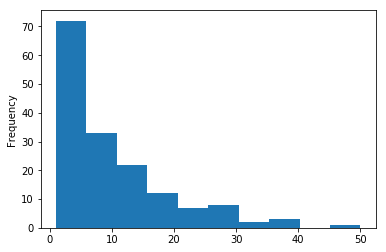

In [56]:
 very.plot.hist()

As the histogram above shows, most trains delay 5 or less trajectories, which is 40% of cases. 

### QUESTION 1.B : Analyzing the most delayed train

In [57]:
mostdelayed = df[df['Treinnummer'] == 2132]

In [58]:
unique_counts(mostdelayed)

Date van vertrek : 1
Treinnummer : 3799
Relatie : 104
Spoorwegoperatoren : 3
Spoorlijn van vertrek : 136
Uur van reële aankomst : 42534
Uur van reële vertrek : 42468
Uur van geplande aankomst : 1433
Uur van geplande vertrek : 1396
Vertraging bij aankomst : 1923
Vertraging bij vertrek : 1879
Richting van de relatie : 204
Naam van de halte : 625
Spoorlijn van aankomst : 136
Datum van geplande aankomst : 2
Datum van geplande vertrek : 2
Datum van reële aankomst : 2
Datum van reële vertrek : 2


In [59]:
mostdelayed.describe()

,Treinnummer,Vertraging bij aankomst,Vertraging bij vertrek
count,57.0,57.000000,56.000000
mean,2132.0,1092.508772,1109.285714
std,0.0,363.032964,330.334085
min,2132.0,-131.000000,237.000000
25%,2132.0,1010.000000,1010.000000
50%,2132.0,1255.000000,1227.000000
75%,2132.0,1356.000000,1357.000000
max,2132.0,1407.000000,1458.000000


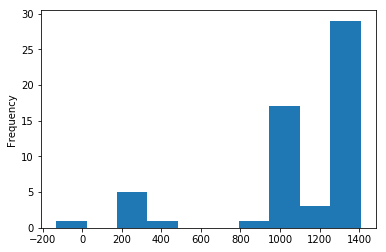

In [60]:
mostdelayed['Vertraging bij aankomst'].plot.hist(bins=10)

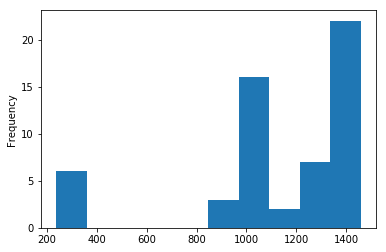

In [64]:
mostdelayed['Vertraging bij vertrek'].plot.hist(bins=10)

1

In [73]:
delayperstation = mostdelayed.groupby('Naam van de halte')[['Vertraging bij aankomst', 'Vertraging bij vertrek']].sum()

type(delayperstation)

pandas.core.frame.DataFrame

In [80]:
perstation = delayperstation.reset_index()

perstation

,Naam van de halte,Vertraging bij aankomst,Vertraging bij vertrek
0,ARLON,-131.0,237.0
1,ASSESSE,1010.0,1010.0
2,AYE,1023.0,1023.0
3,BEUZET,1357.0,1357.0
4,BLANMONT,1338.0,1338.0
5,BOIS D'AUSSE,1010.0,1010.0
6,BOSVOORDE,1262.0,1262.0
7,BRUSSEL-CENTRAAL,1205.0,1207.0
8,BRUSSEL-CONGRES,1226.0,1226.0
9,BRUSSEL-KAPELLEKERK,1178.0,1178.0


In [81]:
perstation.columns

Index(['Naam van de halte', 'Vertraging bij aankomst',
       'Vertraging bij vertrek'],
      dtype='object')

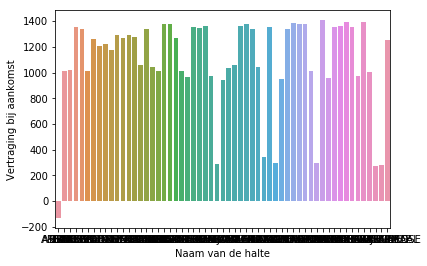

In [85]:
sns.barplot(x= 'Naam van de halte', y= 'Vertraging bij aankomst', data= perstation)

## 2) Data frame

We consider that passengers will wait maximum 15 minutes before considering to take another route, which is 900 seconds. We will reduce the set to these data.

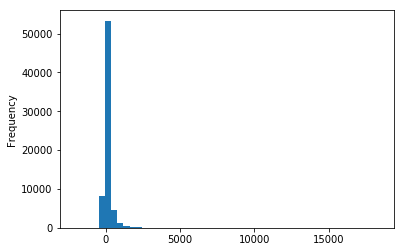

In [61]:
df['Vertraging bij aankomst'].plot.hist(bins=50)

In [14]:
data = df[(df['Vertraging bij aankomst'] <= 900) & (df['Vertraging bij vertrek'] <= 900)]

We reduced the dataframe from 67960 to 48821 entries

In [15]:
#The value of 300 seconds (5 minutes) is given by observing the distribution function

data = data[(data['Vertraging bij aankomst'] > -300) & (data['Vertraging bij vertrek'] > - 300)]

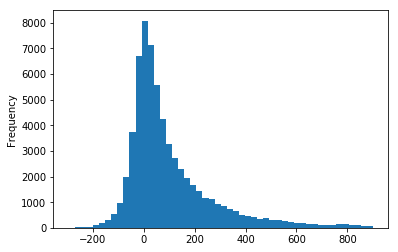

In [16]:
data['Vertraging bij aankomst'].plot.hist(bins=50)

In [49]:
data.describe()

,Treinnummer,Vertraging bij aankomst,Vertraging bij vertrek
count,63197.000000,63197.000000,63197.000000
mean,3476.822365,101.318781,107.738342
std,2319.557287,170.939532,169.111983
min,11.000000,-295.000000,-295.000000
25%,1988.000000,-5.000000,4.000000
50%,3037.000000,46.000000,51.000000
75%,4414.000000,154.000000,157.000000
max,19975.000000,900.000000,899.000000


### Use case: Trains going to Luxembourg

In [18]:
luxembourg = data[data['Richting van de relatie'] == 'IC 33: LUXEMBOURG -> LIERS']

In [48]:
data['Richting van de relatie']

0                          IC 33: LUXEMBOURG -> LIERS
1                           L B6: AALST -> SCHAARBEEK
2                          IC 33: LUXEMBOURG -> LIERS
3                           L B6: AALST -> SCHAARBEEK
4                          IC 33: LUXEMBOURG -> LIERS
5                          IC 33: LUXEMBOURG -> LIERS
6                         IC 03: GENK -> BLANKENBERGE
7                         IC 03: GENK -> BLANKENBERGE
8                         IC 03: GENK -> BLANKENBERGE
9                         IC 03: GENK -> BLANKENBERGE
10                        IC 03: GENK -> BLANKENBERGE
11                        IC 03: GENK -> BLANKENBERGE
12                        IC 03: GENK -> BLANKENBERGE
13                        IC 03: GENK -> BLANKENBERGE
14                        IC 03: GENK -> BLANKENBERGE
15                        IC 03: GENK -> BLANKENBERGE
16                        IC 03: GENK -> BLANKENBERGE
17                        IC 03: GENK -> BLANKENBERGE
18                        IC

In [45]:
man = luxembourg.groupby('Treinnummer') 

man

In [46]:
luxembourg.groupby(['Treinnummer', 'Naam van de halte'])['Vertraging bij vertrek']

In [41]:
suma = luxembourg.groupby('Treinnummer')[['Vertraging bij aankomst', 'Vertraging bij vertrek']].sum()

suma

,Vertraging bij aankomst,Vertraging bij vertrek
Treinnummer,,
109,2015.0,2115.0
111,-80.0,120.0
113,1344.0,1217.0
115,-219.0,-137.0
117,-410.0,-283.0
119,455.0,280.0
121,4585.0,4601.0
123,3073.0,2845.0


In [125]:
data['Vertraging bij aankomst']/suma['Vertraging bij aankomst']

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
5       NaN
6       NaN
7       NaN
8       NaN
9       NaN
10      NaN
11      NaN
12      NaN
13      NaN
14      NaN
15      NaN
16      NaN
17      NaN
18      NaN
19      NaN
20      NaN
21      NaN
22      NaN
23      NaN
25      NaN
26      NaN
27      NaN
         ..
71690   NaN
71692   NaN
71693   NaN
71694   NaN
71695   NaN
71696   NaN
71698   NaN
71699   NaN
71700   NaN
71701   NaN
71702   NaN
71705   NaN
71706   NaN
71707   NaN
71708   NaN
71709   NaN
71710   NaN
71711   NaN
71712   NaN
71713   NaN
71714   NaN
71715   NaN
71716   NaN
71718   NaN
71721   NaN
71735   NaN
71737   NaN
Name: Vertraging bij aankomst, Length: 63197, dtype: float64

In [88]:
 data2 = data

In [97]:
data2['richting_a'],  data2['richting_b'] = data2['Richting van de relatie'].str.split("->").str


In [101]:
 data2['operator'], data2['richting_a'] = data2['richting_a'].str.split(":").str

In [102]:
data2

,Date van vertrek,Treinnummer,Relatie,Spoorwegoperatoren,Spoorlijn van vertrek,Uur van reële aankomst,Uur van reële vertrek,Uur van geplande aankomst,Uur van geplande vertrek,Vertraging bij aankomst,...,Richting van de relatie,Naam van de halte,Spoorlijn van aankomst,Datum van geplande aankomst,Datum van geplande vertrek,Datum van reële aankomst,Datum van reële vertrek,richting_a,richting_b,operator
0,2019-06-13,115,IC 33,SNCB/NMBS,34,2019-06-19 16:08:02,2019-06-19 16:08:43,2019-06-19 16:08:00,2019-06-19 16:09:00,2.0,...,IC 33: LUXEMBOURG -> LIERS,LIEGE-SAINT-LAMBERT,34,2019-06-13,2019-06-13,2019-06-13,2019-06-13,LUXEMBOURG,LIERS,IC 33
1,2019-06-13,1569,L B6,SNCB/NMBS,90,2019-06-19 19:56:36,2019-06-19 19:57:54,2019-06-19 19:55:00,2019-06-19 19:56:00,96.0,...,L B6: AALST -> SCHAARBEEK,DENDERLEEUW,50,2019-06-13,2019-06-13,2019-06-13,2019-06-13,AALST,SCHAARBEEK,L B6
2,2019-06-13,115,IC 33,SNCB/NMBS,42,2019-06-19 14:59:38,2019-06-19 15:01:26,2019-06-19 15:00:00,2019-06-19 15:01:00,-22.0,...,IC 33: LUXEMBOURG -> LIERS,TROIS-PONTS,42,2019-06-13,2019-06-13,2019-06-13,2019-06-13,LUXEMBOURG,LIERS,IC 33
3,2019-06-13,1569,L B6,SNCB/NMBS,123,2019-06-19 20:36:51,2019-06-19 20:36:51,2019-06-19 20:37:00,2019-06-19 20:37:00,-9.0,...,L B6: AALST -> SCHAARBEEK,TOLLEMBEEK,123,2019-06-13,2019-06-13,2019-06-13,2019-06-13,AALST,SCHAARBEEK,L B6
4,2019-06-13,115,IC 33,SNCB/NMBS,34,2019-06-19 16:04:03,2019-06-19 16:06:02,2019-06-19 16:05:00,2019-06-19 16:06:00,-57.0,...,IC 33: LUXEMBOURG -> LIERS,LIEGE-CARRE,34,2019-06-13,2019-06-13,2019-06-13,2019-06-13,LUXEMBOURG,LIERS,IC 33
5,2019-06-13,115,IC 33,SNCB/NMBS,43,2019-06-19 15:40:20,2019-06-19 15:40:20,2019-06-19 15:41:00,2019-06-19 15:41:00,-40.0,...,IC 33: LUXEMBOURG -> LIERS,HONY,43,2019-06-13,2019-06-13,2019-06-13,2019-06-13,LUXEMBOURG,LIERS,IC 33
6,2019-06-13,1528,IC 03,SNCB/NMBS,50A,2019-06-19 07:27:29,2019-06-19 07:28:11,2019-06-19 07:22:00,2019-06-19 07:26:00,329.0,...,IC 03: GENK -> BLANKENBERGE,GENT-SINT-PIETERS,50A,2019-06-13,2019-06-13,2019-06-13,2019-06-13,GENK,BLANKENBERGE,IC 03
7,2019-06-13,1528,IC 03,SNCB/NMBS,36N,2019-06-19 06:28:17,2019-06-19 06:28:17,2019-06-19 06:26:00,2019-06-19 06:26:00,137.0,...,IC 03: GENK -> BLANKENBERGE,ERPS-KWERPS,36N,2019-06-13,2019-06-13,2019-06-13,2019-06-13,GENK,BLANKENBERGE,IC 03
8,2019-06-13,1528,IC 03,SNCB/NMBS,36N,2019-06-19 06:29:17,2019-06-19 06:29:17,2019-06-19 06:27:00,2019-06-19 06:27:00,137.0,...,IC 03: GENK -> BLANKENBERGE,KORTENBERG,36N,2019-06-13,2019-06-13,2019-06-13,2019-06-13,GENK,BLANKENBERGE,IC 03
9,2019-06-13,1528,IC 03,SNCB/NMBS,36,2019-06-19 06:36:42,2019-06-19 06:36:42,2019-06-19 06:35:00,2019-06-19 06:35:00,102.0,...,IC 03: GENK -> BLANKENBERGE,SCHAARBEEK,36,2019-06-13,2019-06-13,2019-06-13,2019-06-13,GENK,BLANKENBERGE,IC 03


In [115]:
group_a= data2.groupby(['richting_a', 'richting_b'])[['richting_a', 'richting_b']].count()

In [127]:
group_b =  data2.groupby(['richting_b', 'richting_a'])[['richting_a', 'richting_b']].count()

group_b

richting_a  richting_b
richting_b               richting_a                                           
 AACHEN HBF               SPA-GERONSTERE                        15          15
 AALST                    BRUSSEL-ZUID                         270         270
                          SCHAARBEEK                           459         459
                          VILVOORDE                            265         265
 AMSTERDAM CENTRAAL       BRUSSEL-ZUID                         333         333
                          PARIS-NORD                           229         229
 ANTWERPEN-CENTRAAL       BRUSSEL-ZUID                         354         354
                          DE PANNE                             425         425
                          HAMONT                               281         281
                          HASSELT                              509         509
                          LEUVEN                               358         358
                          LOKEREN                              210         210
                          MOL                                  176         176
                          NIVELLES                             966         966
                          OOSTENDE                             457         457
                          POPERINGE                            567         567
                          TURNHOUT                             148         148
 ANTWERPEN-NOORDERDOKKEN  CHARLEROI-SUD                        553         553
 ARLON                    LIBRAMONT                            115         115
 BINCHE                   TURNHOUT                             519         519
 BLANKENBERGE             GENK                                 643         643
 BRAINE-L'ALLEUD          LEUVEN                               426         426
 BRAINE-LE-COMTE          JURBISE                               56          56
                          LA LOUVIERE-SUD                       72          72
                          LEUVEN                               768         768
 BRUGGE                   KORTRIJK                             122         122
 BRUSSEL-ZUID             AALST                                270         270
...                                                            ...         ...
 OTTIGNIES                NAMUR                                160         160
 PARIS-NORD               AMSTERDAM CENTRAAL                   238         238
                          KOLN HBF                              83          83
 POPERINGE                ANTWERPEN-CENTRAAL                   552         552
 PUURS                    ESSEN                                624         624
 QUEVY                    TOURNAI                              215         215
 QUEVY-FRONTIERE          MONS                                   6           6
 QUIEVRAIN                LIEGE-GUILLEMINS                     907         907
 RONSE                    EEKLO                                250         250
 SCHAARBEEK               AALST                                464         464
 SINT-NIKLAAS             KORTRIJK                             609         609
                          LEUVEN                               239         239
 SPA-GERONSTERE           AACHEN HBF                            15          15
 TONGEREN                 GENT-SINT-PIETERS                    650         650
 TOURNAI                  BRUSSELS AIRPORT - ZAVENTEM          344         344
                          LILLE FLANDRES                        16          16
                          NAMUR                                706         706
                          QUEVY                                231         231
 TURNHOUT                 ANTWERPEN-CENTRAAL                   151         151
                          BINCHE                               568         568
 VERVIERS-CENTRAL         HERSTAL                              128         128
 VILVOORDE                A

In [128]:
#sort by 

group_c =  data2.groupby(['richting_b'])[['richting_a', 'richting_b']].count()
group_c.describe()

,richting_a,richting_b
count,80.000000,80.000000
mean,725.950000,725.950000
std,822.859016,822.859016
min,6.000000,6.000000
25%,197.250000,197.250000
50%,494.000000,494.000000
75%,928.750000,928.750000
max,4451.000000,4451.000000


In [133]:
group_a.head(30)

richting_a  richting_b
richting_a                richting_b                                 
 AACHEN HBF                SPA-GERONSTERE              15          15
 AALST                     BRUSSEL-ZUID               270         270
                           SCHAARBEEK                 464         464
                           VILVOORDE                  286         286
 AMSTERDAM CENTRAAL        BRUSSEL-ZUID               330         330
                           PARIS-NORD                 238         238
 ANTWERPEN-CENTRAAL        BRUSSEL-ZUID               328         328
                           DE PANNE                   425         425
                           HAMONT                     264         264
                           HASSELT                    507         507
                           LEUVEN                     387         387
                           LOKEREN                    206         206
                           MOL                        176         176
                           NIVELLES                  1052        1052
                           OOSTENDE                   427         427
                           POPERINGE                  552         552
                           TURNHOUT                   151         151
 ANTWERPEN-NOORDERDOKKEN   CHARLEROI-SUD              491         491
 ARLON                     LIBRAMONT                  122         122
 BINCHE                    TURNHOUT                   568         568
 BLANKENBERGE              GENK                       631         631
 BRAINE-L'ALLEUD           LEUVEN                     425         425
 BRAINE-LE-COMTE           JURBISE                     56          56
                           LA LOUVIERE-SUD             67          67
                           LEUVEN                     732         732
 BRUGGE                    KORTRIJK                   130         130
 BRUSSEL-ZUID              AALST                      270         270
                           AMSTERDAM CENTRAAL         333         333
                           ANTWERPEN-CENTRAAL         354         354
                           DENDERMONDE                169         169

In [132]:
group_b.head(30)

richting_a  richting_b
richting_b               richting_a                                  
 AACHEN HBF               SPA-GERONSTERE               15          15
 AALST                    BRUSSEL-ZUID                270         270
                          SCHAARBEEK                  459         459
                          VILVOORDE                   265         265
 AMSTERDAM CENTRAAL       BRUSSEL-ZUID                333         333
                          PARIS-NORD                  229         229
 ANTWERPEN-CENTRAAL       BRUSSEL-ZUID                354         354
                          DE PANNE                    425         425
                          HAMONT                      281         281
                          HASSELT                     509         509
                          LEUVEN                      358         358
                          LOKEREN                     210         210
                          MOL                         176         176
                          NIVELLES                    966         966
                          OOSTENDE                    457         457
                          POPERINGE                   567         567
                          TURNHOUT                    148         148
 ANTWERPEN-NOORDERDOKKEN  CHARLEROI-SUD               553         553
 ARLON                    LIBRAMONT                   115         115
 BINCHE                   TURNHOUT                    519         519
 BLANKENBERGE             GENK                        643         643
 BRAINE-L'ALLEUD          LEUVEN                      426         426
 BRAINE-LE-COMTE          JURBISE                      56          56
                          LA LOUVIERE-SUD              72          72
                          LEUVEN                      768         768
 BRUGGE                   KORTRIJK                    122         122
 BRUSSEL-ZUID             AALST                       270         270
                          AMSTERDAM CENTRAAL          330         330
                          ANTWERPEN-CENTRAAL          328         328
                          DENDERMONDE                 168         168

In [130]:
group_c

,richting_a,richting_b
richting_b,,
AACHEN HBF,15,15
AALST,994,994
AMSTERDAM CENTRAAL,562,562
ANTWERPEN-CENTRAAL,4451,4451
ANTWERPEN-NOORDERDOKKEN,553,553
ARLON,115,115
BINCHE,519,519
BLANKENBERGE,643,643
BRAINE-L'ALLEUD,426,426


In [134]:
#Link with the file of importannt stations